In [1]:
import os
import numpy as np
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld, ToTensord,
    ScaleIntensityd,SpatialPadd,
    LambdaD
)
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.networks.nets import UNETR
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.metrics import DiceMetric

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

In [2]:
# printing the results

# Define the transformation pipeline for the single image
def threshold_image(image):
    return np.where(image < 20, 0, image)

single_image_transforms = Compose(
    [
        LoadImaged(keys=["image"], reader="nrrdreader"),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityd(keys=["image"], minv=0, maxv=255),
        LambdaD(keys="image", func=threshold_image),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys="image", spatial_size=(64, 64, 64)),
        ToTensord(keys=["image"]),
    ]
)


# Example NRRD file path
image_file = "./Data/FrenchSpeakerDataset/Segmentations_Val/P1_2.nrrd"

# Create a dictionary for the single image
single_image_data = [{"image": image_file}]

# Create a Dataset for the single image
single_image_ds = CacheDataset(data=single_image_data, transform=single_image_transforms,
                      cache_num=6, cache_rate=1.0, num_workers=4)

# Load and preprocess the image
single_image_loader = DataLoader(single_image_ds, batch_size=1)
single_image_batch = next(iter(single_image_loader))
single_image = single_image_batch["image"]

# Print the shape of the preprocessed image
print(f"Preprocessed image shape: {single_image.shape}")


/home/erattakulangara/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

Preprocessed image shape: torch.Size([1, 1, 288, 319, 64])


In [3]:
import tqdm
# Define the model (for example, UNet)
model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(64, 64, 64),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="conv",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.5,
)

# Load pre-trained model weights (modify the path as needed)
model.load_state_dict(torch.load(
    "./logs/FineTune/FrenchSpeaker-Thresh-255-10000St.pth"))
model.eval()

# Perform inference

with torch.no_grad():
        single_image = single_image
        output = sliding_window_inference(single_image,(64, 64, 64), 1, model)

# Convert the output to a binary mask
# output = torch.argmax(output, dim=1).cpu().numpy()
print(f"Segmentation output shape: {output.shape}")


/home/erattakulangara/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


Segmentation output shape: torch.Size([1, 2, 288, 319, 64])


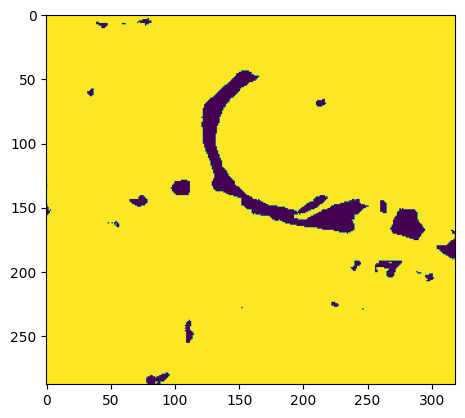

In [8]:
import matplotlib.pyplot as plt
plt.imshow(output[0,0,:,:,35]>0.2)

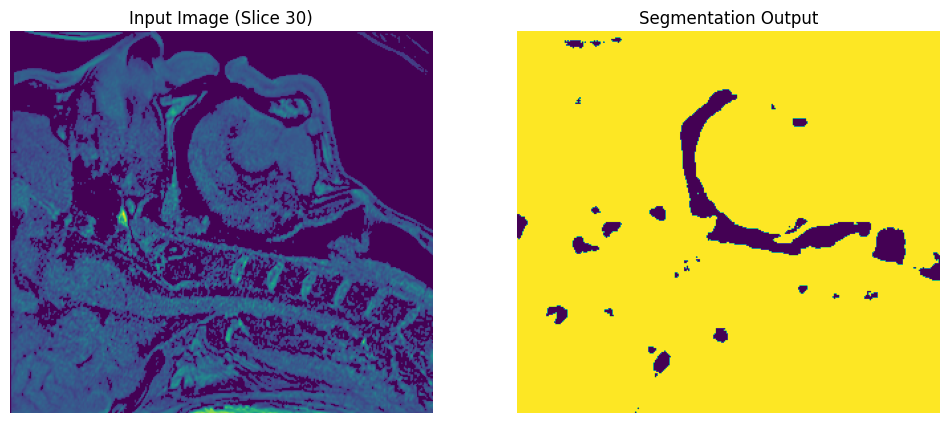

In [10]:
import matplotlib.pyplot as plt
# Extract a slice from the input image and the segmentation output
slice = 30

input_slice = single_image[0, 0, :, :, slice].cpu().numpy()  # Extracting slice 16
output_slice = output[0,0, :, :, slice]>0.2  # Extracting the same slice from the output

# Visualize input and output as subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Input image subplot
axes[0].imshow(input_slice)
axes[0].set_title(f"Input Image (Slice {slice})")
axes[0].axis("off")

# Segmentation output subplot
axes[1].imshow(output_slice)
axes[1].set_title("Segmentation Output")
axes[1].axis("off")

plt.show()
